In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    
    accuracy = accuracy_score(y_test , pred)
    
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    
    f1 = f1_score(y_test,pred)
    
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
    
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('./titanic/titanic_train.csv')
predict_df = pd.read_csv('./titanic/test.csv')
gender_submission_df = pd.read_csv('./titanic/gender_submission.csv')

# 알파벳 뒤에 붙는 숫자 값은 무시하고 Alphabet만 가져오는 전략을 선택
train_df['Cabin'] = train_df['Cabin'].str[:1]

def get_category_age(age):
    cat = ''
    if age <= -1: cat = 0
    elif age <= 5: cat = 1
    elif age <= 12: cat = 2
    elif age <= 18: cat = 3
    elif age <= 25: cat = 4
    elif age <= 35: cat = 5
    elif age <= 60: cat = 6
    else: cat = 7
               
    return cat

group_names = [0, 1, 2, 3, 4, 5, 6, 7]
train_df['Age_range'] = train_df['Age'].apply(lambda x : get_category_age(x))

def get_category_fare(fare):
    cat = ''
    if fare <= 0: cat = 0
    elif fare <= 10: cat = 1
    elif fare <= 20: cat = 2
    elif fare <= 30: cat = 3
    elif fare <= 40: cat = 4
    elif fare <= 50: cat = 5
    elif fare <= 60: cat = 6
    else: cat = 7
               
    return cat

group_names = [0, 1, 2, 3, 4, 5, 6, 7]
train_df['Fare_range'] = train_df['Fare'].apply(lambda x : get_category_fare(x))

# 불필요한 특성, null 값 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket', 'Age', 'Fare'], axis=1, inplace=True)

    y = df['Survived']
    df = df.drop('Survived', axis=1, inplace=False)
    return df, y

def fillna(df):
    df['Cabin'] = df['Cabin'].fillna('N')
    df['Embarked'] = df['Embarked'].fillna('N')
    return df
# predict_df에서 사용
def drop_features_update(df):
    df.drop(['PassengerId','Name','Ticket', 'Age', 'Fare'], axis=1, inplace=True)
    return df

train_df = fillna(train_df)
X, y = drop_features(train_df)


# 라벨 인코딩 구현
# Sex
def get_category_sex(sex):
    cat = ''
    if sex == "male": cat = 0
    else: cat = 1
    return cat

group_names = [0, 1]
X['Sex'] = X['Sex'].apply(lambda x : get_category_sex(x))

# Embarked
def get_category_embarked(embarked):
    cat = ''
    if embarked == "S": cat = 0
    elif embarked == "C": cat= 1
    elif embarked == "Q": cat= 2
    else: cat = 3
    return cat

group_names = [0, 1, 2, 3]
X['Embarked'] = X['Embarked'].apply(lambda x : get_category_embarked(x))

# Cabin
def get_category_cabin(cabin):
    cat = ''
    if cabin == "A": cat = 0
    elif cabin == "B": cat= 1
    elif cabin == "C": cat= 2
    elif cabin == "D": cat= 3
    elif cabin == "E": cat= 4
    elif cabin == "F": cat= 5
    elif cabin == "G": cat= 6
    elif cabin == "N": cat= 7
    else: cat = 8
    return cat

group_names = [0, 1, 2, 3, 4, 5, 6, 7, 8]
X['Cabin'] = X['Cabin'].apply(lambda x : get_category_cabin(x))

X.head()

,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Age_range,Fare_range
0,3,0,1,0,7,0,4,1
1,1,1,1,0,2,1,6,7
2,3,1,0,0,7,0,5,1
3,1,1,1,0,2,0,5,6
4,3,0,0,0,7,0,5,1


In [232]:
from sklearn.preprocessing import StandardScaler

# 표준화 => 2차원 데이터
sc = StandardScaler()
X = sc.fit_transform(X)
X[1]

array([-1.56610693,  1.35557354,  0.43279337, -0.47367361, -1.91449093,
        0.97626307,  0.58683487,  1.98498764])

In [243]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# predict_df 변환

In [249]:
predict_df['Age_range'] = predict_df['Age'].apply(lambda x : get_category_age(x))

predict_df['Fare_range'] = predict_df['Fare'].apply(lambda x : get_category_fare(x))

predict_df = fillna(predict_df)
predict_df = drop_features_update(predict_df)

predict_df['Sex'] = predict_df['Sex'].apply(lambda x : get_category_sex(x))
predict_df['Embarked'] = predict_df['Embarked'].apply(lambda x : get_category_embarked(x))

predict_df['Cabin'] = predict_df['Cabin'].str[:1]
predict_df['Cabin'] = predict_df['Cabin'].apply(lambda x : get_category_cabin(x))

predict_df.head(3)

,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Age_range,Fare_range
0,3,0,0,0,7,2,5,1
1,3,1,1,0,7,0,6,1
2,2,0,0,0,7,2,7,1


In [250]:
predict_df = sc.transform(predict_df)
predict_df[1]

array([ 0.82737724,  1.35557354,  0.43279337, -0.47367361,  0.51129323,
       -0.56876427,  0.58683487, -0.85389516])

## Voting

In [110]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# 개별 모델은 로지스틱 회귀와 KNN, DT
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)
dt = DecisionTreeClassifier()

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf), ('KNN',knn_clf), ('DT', dt)], voting='soft')

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
vo_pred = vo_clf.predict(X_test)
vo_pred_proba = vo_clf.predict_proba(X_test)[:, 1]
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , vo_pred)))
print(f"train score: {vo_clf.score(X_train, y_train)}")
print(f"test score: {vo_clf.score(X_test, y_test)}")
print("\n")

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf, dt]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.8492
train score: 0.8918539325842697
test score: 0.8491620111731844


LogisticRegression 정확도: 0.8156
KNeighborsClassifier 정확도: 0.8324
DecisionTreeClassifier 정확도: 0.8324


In [111]:
get_clf_eval(y_test , vo_pred, vo_pred_proba)

오차 행렬
[[102   8]
 [ 19  50]]
정확도: 0.8492, 정밀도: 0.8621, 재현율: 0.7246,    F1: 0.7874, AUC:0.9053


In [113]:
predict_titanic_pred_voting = vo_clf.predict(predict_df)
print(f"predict_titanic_Voting 예측: {predict_titanic_pred_voting}")

gender_submission_df['Survived'] = predict_titanic_pred_voting
gender_submission_df.to_csv('titanic_submission_voting.csv',index=False)
gender_submission_df

predict_titanic_Voting 예측: [0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 1 0 1 0 0 0]


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## randomforest

랜덤 포레스트 정확도: 0.8324
train 정확도: 0.8890449438202247
test 정확도: 0.8324022346368715 

Feature importances:
[0.104 0.382 0.068 0.056 0.099 0.052 0.134 0.103] 

Pclass: 0.104
Sex: 0.382
SibSp: 0.068
Parch: 0.056
Cabin: 0.099
Embarked: 0.052
Age_range: 0.134
Fare_range: 0.103


<Axes: ylabel='None'>

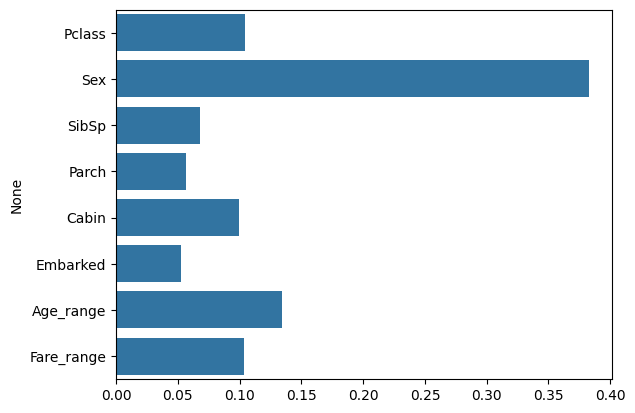

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=8)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))
print(f"train 정확도: {rf_clf.score(X_train, y_train)}")
print(f"test 정확도: {rf_clf.score(X_test, y_test)}", "\n")

# feature importance 추출 
feature_names = train_df.columns.drop('Survived')
print("Feature importances:\n{0}".format(np.round(rf_clf.feature_importances_, 3)), "\n")

# feature별 importance 매핑
for name, value in zip(feature_names , rf_clf.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))

# feature importance를 column 별로 시각화 하기 
sns.barplot(x=rf_clf.feature_importances_ , y=feature_names)

In [127]:
rf_pred = rf_clf.predict(X_test) 
print(rf_pred)

rf_proba = rf_clf.predict_proba(X_test)[:, 1]
print(rf_proba[:4])

get_clf_eval(y_test , rf_pred, rf_proba)

[0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0
 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1
 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0]
[0.17208739 0.09665921 0.04746126 0.96454545]
오차 행렬
[[101   9]
 [ 21  48]]
정확도: 0.8324, 정밀도: 0.8421, 재현율: 0.6957,    F1: 0.7619, AUC:0.8974


In [116]:
predict_titanic_pred_rf = rf_clf.predict(predict_df)
print(f"predict_titanic_Voting 예측: {predict_titanic_pred_rf}")

gender_submission_df['Survived'] = predict_titanic_pred_rf
gender_submission_df.to_csv('titanic_submission_rf.csv',index=False)
gender_submission_df

predict_titanic_Voting 예측: [0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 1 0 1 0 0 0]


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


최적 하이퍼 파라미터:
 {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 18}
최고 예측 정확도: 0.8146
train 정확도: 0.8623595505617978
test 정확도: 0.8100558659217877
Feature importances:
[0.113 0.443 0.054 0.054 0.096 0.039 0.103 0.098] 

Pclass: 0.113
Sex: 0.443
SibSp: 0.054
Parch: 0.054
Cabin: 0.096
Embarked: 0.039
Age_range: 0.103
Fare_range: 0.098


<Axes: ylabel='None'>

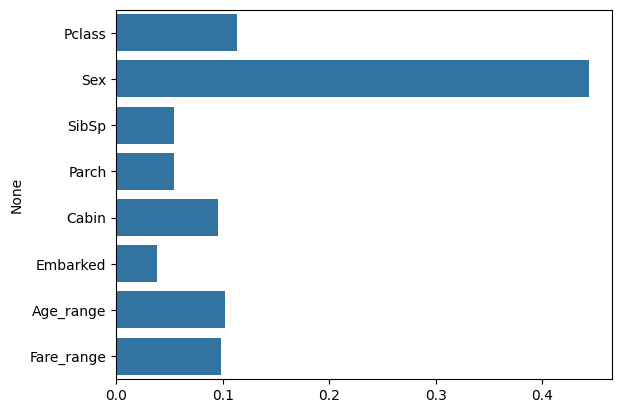

In [130]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': np.arange(1, 30, 1),
    'min_samples_leaf' : np.arange(1, 20, 1),
    'min_samples_split' : np.arange(2, 20, 1)
}

rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

print(f"train 정확도: {grid_cv.score(X_train, y_train)}")
print(f"test 정확도: {grid_cv.score(X_test, y_test)}")


best_rf = grid_cv.best_estimator_

# feature importance 추출 
feature_names = train_df.columns.drop('Survived')
print("Feature importances:\n{0}".format(np.round(best_rf.feature_importances_, 3)), "\n")

# feature별 importance 매핑
for name, value in zip(feature_names , best_rf.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))

# feature importance를 column 별로 시각화 하기 
sns.barplot(x=best_rf.feature_importances_ , y=feature_names)

In [132]:
print(f"best_train 정확도: {best_rf.score(X_train, y_train)}")
print(f"best_test 정확도: {best_rf.score(X_test, y_test)}")

best_rf_pred = best_rf.predict(X_test) 
print(best_rf_pred)

best_rf_proba = best_rf.predict_proba(X_test)[:, 1]
print(best_rf_proba[:4])

get_clf_eval(y_test , best_rf_pred, best_rf_proba)

best_train 정확도: 0.8623595505617978
best_test 정확도: 0.8100558659217877
[0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0
 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1
 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0]
[0.17021883 0.07790908 0.17766183 0.90188962]
오차 행렬
[[100  10]
 [ 24  45]]
정확도: 0.8101, 정밀도: 0.8182, 재현율: 0.6522,    F1: 0.7258, AUC:0.9127


In [133]:
predict_titanic_pred_rf_best = best_rf.predict(predict_df)
# print(f"predict_titanic_Voting 예측: {predict_titanic_pred_rf_best}")

gender_submission_df['Survived'] = predict_titanic_pred_rf_best
gender_submission_df.to_csv('titanic_submission_rf_best.csv',index=False)
gender_submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# voting에 rf 추가

In [145]:
# VotingClassifier에 RandomForestClassifier 추가
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)
dt = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf_rf = VotingClassifier( estimators=[('LR',lr_clf), ('KNN',knn_clf), ('DT', dt), ('RF', rf_clf)], voting='soft')

# VotingClassifier 학습/예측/평가. 
vo_clf_rf.fit(X_train , y_train)
pred_vo_plus = vo_clf.predict(X_test)
pred_proba_vo_plus = vo_clf_rf.predict_proba(X_test)[:, 1] # 분류 결정 예측 확률
print('Voting Plus RF 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))
print(f"train 정확도: {vo_clf_rf.score(X_train, y_train)}")
print(f"test 정확도: {vo_clf_rf.score(X_test, y_test)}", "\n")

get_clf_eval(y_test , pred_vo_plus, pred_proba_vo_plus)

Voting Plus RF 분류기 정확도: 0.8324
train 정확도: 0.9058988764044944
test 정확도: 0.8379888268156425 

오차 행렬
[[102   8]
 [ 19  50]]
정확도: 0.8492, 정밀도: 0.8621, 재현율: 0.7246,    F1: 0.7874, AUC:0.9020


In [137]:
predict_titanic_pred_rf_plus = vo_clf_rf.predict(predict_df)
# print(f"predict_titanic_Voting 예측: {predict_titanic_pred_rf_best}")

gender_submission_df['Survived'] = predict_titanic_pred_rf_plus
gender_submission_df.to_csv('titanic_submission_rf_plus.csv',index=False)
gender_submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# 반대로 큰 값을 적용하면 최소 오류 값을 찾지 못하고 그냥 지나쳐 예측 성능이 떠러질 가능성이 높지만 빠른 수행이 가능하다.GBM
> - Gradient Boosting 알고리즘을 사용하는 분류 모델
> - Gradient Boosting은 약한 학습기(weak learner)를 순차적으로 결합하여 강력한 예측 모델을 만드는 앙상블 학습 기법
> - 가중치 업데이트를 경사 하강법을 이용
> - 오류 값 = 실제 값 - 예측 값 -> h(x) = y-F(x)
> - 경사 하강법은 반복 수행을 통해 오류를 최소화할 수 있도록 가중치의 업데이트 값을 도출하는 기법으로서 머신러닝에서 중요한 기법 중 하나

> - 약한 학습기: GradientBoostingClassifier는 주로 의사결정 나무(Decision Tree)를 약한 학습기로 사용합니다. 각 약한 학습기는 복잡도가 낮고 예측 성능이 약하지만, 이들을 순차적으로 결합하면 강력한 모델을 만들 수 있습니다.
> - 단계적 학습: 모델은 단계적으로 학습됩니다. 첫 번째 약한 학습기가 학습된 후, 이 모델의 오차를 최소화하는 방향으로 두 번째 약한 학습기가 학습됩니다. 이러한 과정을 반복하여 최종 모델을 구축합니다.
> - 오차 최소화: 각 단계에서는 이전 단계의 오차를 최소화하는 방향으로 새로운 약한 학습기를 학습시킵니다. 이를 통해 전체 모델의 예측 성능을 점진적으로 향상시킬 수 있습니다.
> - 정규화: GradientBoostingClassifier는 과적합을 방지하기 위해 다양한 정규화 기법을 제공합니다. 예를 들어 learning_rate, max_depth, subsample 등의 하이퍼파라미터를 조정하여 모델의 복잡도를 제어할 수 있습니다.
> - radientBoostingClassifier는 비선형 관계, 높은 차원의 데이터, 이상치 등이 포함된 문제에서 강점을 발휘하며, 특히 분류 문제에 효과적입니다. 또한 데이터 전처리나 특징 엔지니어링 없이도 좋은 성능을 보이는 경우가 많아 실무에서 널리 사용되는 모델 중 하나



> -  하이퍼파라미터
> -  learning_rate=학습을 진행할 때마다 적용하는 학습률, Weak learner가 순차적으로 오류 값을 보정해 나가는 데 적용하는 계수이다. 0~1 사이의 값을 지정할 수 있으며 기본값은 0.1이다. 

> - 너무 작은 값을 적용하면 업데이트되는 값이 작아져 최소 오류 값을 찾아 예측 성능이 높아질 가능성이 높다. 하지만 많은 Weak learner는 순차적인 반복이 필요해서 수행 시간이 오래 걸리고, 또 너무 작게 설정하면 모든 Waek learner의 반복이 완료돼도 최소 오류 값을 찾지 못할 수 있다. 

> - 반대로 큰 값을 적용하면 최소 오류 값을 찾지 못하고 그냥 지나쳐 예측 성능이 떠러질 가능성이 높지만 빠른 수행이 가능하다.

> - n_estimators=weak learner의 개수, weak learner가 순차적으로 오류를 보정하므로 개수가 많을 수록 예측 성능이 일정 수준까지는 좋아질 수 있다. 하지만 개수가 많을 수록 수행 시간이 오래 걸린다. 기본 값은 100

> - subsample=weak learner가 학습에 사용하는 데이터의 샘플링 비율, 기본 값은 1이며 이는 전체 학습 데이터를 기반으로 학습한다는 의미이다. 0.5이면 학습 데이터의 50%, 과적합이 염려되는 경웅 subsample을 1보다 작은 값으로 설정한다.

In [244]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train , y_train)

gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time), "\n\n")

print(f"GBM - train: {gb_clf.score(X_train, y_train)}")
print(f"GBM - test: {gb_clf.score(X_test, y_test)}")

get_clf_eval(y_test , gb_pred, pred_proba_gb)

GBM 정확도: 0.8324
GBM 수행 시간: 0.1 초  


GBM - train: 0.8623595505617978
GBM - test: 0.8324022346368715
오차 행렬
[[102   8]
 [ 22  47]]
정확도: 0.8324, 정밀도: 0.8545, 재현율: 0.6812,    F1: 0.7581, AUC:0.8953


In [147]:
predict_titanic_pred_gb_clf = gb_clf.predict(predict_df)

gender_submission_df['Survived'] = predict_titanic_pred_gb_clf
gender_submission_df.to_csv('titanic_submission_gb_clf.csv',index=False)
gender_submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [245]:
from sklearn.model_selection import GridSearchCV

start_time = time.time()

params = {
    'n_estimators':np.arange(100, 500, 100),
    'learning_rate' : np.arange(0.05, 0.2, 0.01),
    'max_depth': [2, 3, 4, 5],
    'subsample': np.arange(0.1, 1, 0.1)
}

grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=5 ,verbose=1)
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time), "\n")

gbm_best = grid_cv.best_params_

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.30000000000000004}
최고 예측 정확도: 0.8244
GBM 수행 시간: 1347.4 초  



In [246]:
train_gb_pred = grid_cv.best_estimator_.predict(X_train)
train_gb_accuracy = accuracy_score(y_train, train_gb_pred)
print('train GBM 정확도: {0:.4f}'.format(train_gb_accuracy))

test_gb_pred = grid_cv.best_estimator_.predict(X_test)
test_gb_accuracy = accuracy_score(y_test, test_gb_pred)
print('test GBM 정확도: {0:.4f}'.format(test_gb_accuracy))

train GBM 정확도: 0.8596
test GBM 정확도: 0.8268


In [247]:
gbm_best = grid_cv.best_estimator_
grid_gbm_pred = gbm_best.predict(X_test)
grid_gbm_pred_proba = gbm_best.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , grid_gbm_pred, grid_gbm_pred_proba)

오차 행렬
[[100  10]
 [ 21  48]]
정확도: 0.8268, 정밀도: 0.8276, 재현율: 0.6957,    F1: 0.7559, AUC:0.8762


In [251]:
predict_titanic_pred_gbm_grid = gbm_best.predict(predict_df)

gender_submission_df['Survived'] = predict_titanic_pred_gbm_grid
gender_submission_df.to_csv('titanic_submission_gbm_grid.csv',index=False)
gender_submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
